In [92]:
#Q神经网络
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class state_to_action_mlp(nn.Module):
#     def __init__(self, n_starts,n_actions,hidden_dim = 128): #n_starts与n_actions就是输入与输出得维数
#         super(state_to_action_mlp,self).__init__();
#         self.fc1 = nn.Linear(n_starts,hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim,hidden_dim)
#         self.fc3 = nn.Linear(hidden_dim,n_actions)
    
#     def forward(self,x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

import torch.nn as nn
import torch.nn.functional as F
class state_to_action_mlp(nn.Module):
    def __init__(self, n_states, n_actions,hidden_dim=128):
        super(state_to_action_mlp, self).__init__()
        
        # hidden layer
        self.hidden_layer = nn.Sequential(
            nn.Linear(n_states, hidden_dim),
            nn.ReLU()
        )
        
        #  advantage
        self.advantage_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions)
        )
        
        # value
        self.value_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, state):
        x = self.hidden_layer(state)
        advantage = self.advantage_layer(x)
        value     = self.value_layer(x)
        return value + advantage - advantage.mean()

In [93]:
#定义经验回放
from collections import deque
import random

class replybuffer(object):#经验回放就是一个队列，有对策功能就是输入数据，采样数据
    #作为一个队列其就需要容量和存储的区域，这些我们给了以后就是编写其类内部实现这些函数的功能了
    def __init__(self,capacity:int):
        self.capacity = capacity #定义经验回放的容量
        self.buffle = deque(maxlen=self.capacity)
    def push(self,transitions):
        self.buffle.append(transitions)
    def clear(self):
        self.buffle.clear()
    def sample(self,batch_size,sequntial):
        if batch_size > len(self.buffle):
            batch_size = len(self.buffle)
        if sequntial:
            rand = random.randint(0,len(self.buffle)-batch_size)#从以前的旧数据中进行采样而新进入的数据采样
            batch = [self.buffle[i] for i in range(rand,rand+batch_size)] #从中选取batch_size的数据采样作为数据训练
        else:
            batch = random.sample(self.buffle,batch_size)
        return zip(*batch)#把储存数据的地址给传输回去
    def __len__(self):
        return len(self.buffle)

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
class cnfig(object):
    def __init__(self):
        self.n_states = None  #状态的维度和动作在离散空间的情况下我们是可以自己设定好的，就是固定了输入和我们的输出
        self.n_actions = None  #续上：连续的话需要重新考虑一下
        self.algo_name = 'DoubleDQN' # 算法名称
        self.env_name = 'CartPole-v1' # 环境名称
        self.seed = 1 # 随机种子
        self.train_eps = 100 # 训练回合数
        self.test_eps = 10  # 测试回合数
        self.max_steps = 1000 # 每回合最大步数
        self.gamma = 0.99 # 折扣因子
        self.lr = 0.01 # 学习率
        self.epsilon_start = 0.95 # epsilon初始值
        self.epsilon_end = 0.01 # epsilon最终值
        self.epsilon_decay = 500 # epsilon衰减率
        self.buffer_size = 100000 # ReplayBuffer容量
        self.batch_size = 64 # ReplayBuffer中批次大小
        self.target_update = 800 # 目标网络更新频率
        self.hidden_dim = 256 # 神经网络隐藏层维度
        if torch.cuda.is_available(): # 是否使用GPUs
            self.device = 'cuda'
        else:
            self.device = 'cpu'
def smooth(data, weight=0.9):  
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set_theme(style="whitegrid", context="talk", palette="deep")
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

def print_cfgs(cfg):
    cfg_dict = vars(cfg)
    print("Hyperparameters:")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in cfg_dict.items():
        if v.__class__.__name__ == 'list':
            v = str(v)
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))

In [95]:
from sympy import true
import torch
import torch.optim as optim
import math
import random
import numpy as np

#作为一个强化学习算法其实就是三个主要的函数就是采样/预测/更新，任何强化学习算法都是这三个步骤
class DDQN(object):
    #作为一个强化学习算法其应该拥有状态,奖励，动作，折扣因子，学习率，探索率，是否更新标志
    
    #一般还需要Q表，但是现在是DDQN是神经网络所以我们需要目标网络和策略网络，神经网络就要有优化器，然后我们采样要从经验回访中得到
    
    ##其实就是可以分为#与设备相关#与奖励相关#与探索策略相关#与网络相关   4大类！！！！
    def __init__(self,cfg:cnfig):
        #与设备相关
        self.device = torch.device(cfg.device)
        #与奖励相关
        self.gamma = cfg.gamma
        #与探索策略相关
        self.epslion = cfg.epsilon_start
        self.sample_count = 0
        self.epslion_start = cfg.epsilon_start
        self.epslion_end = cfg.epsilon_end
        self.epslion_decay = cfg.epsilon_decay
        #与网络相关
        self.lr = cfg.lr
        self.state = cfg.n_states
        self.action = cfg.n_actions
        self.batch_size = cfg.batch_size
        self.target_net = state_to_action_mlp(cfg.n_states,cfg.n_actions,hidden_dim=cfg.hidden_dim).to(cfg.device) #这一步直接加载模型到设备上嘛？我不是很理解欸看看是否可以优化
        self.target_update = cfg.target_update
        self.policy_net = state_to_action_mlp(cfg.n_states,cfg.n_actions,hidden_dim=cfg.hidden_dim).to(cfg.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())#把策略网络的参数加载进目标网络
        self.optim = optim.Adam(self.policy_net.parameters(),lr = cfg.lr)
        self.memory = replybuffer(cfg.buffer_size)#经验回访池的大小难道不应该大于batch_size的值从而保证可以接收到更多的数据嘛？
        
        self.update_flag = False

    def sample(self,state):
        self.sample_count += 1
        self.epslion = self.epslion_end + (self.epslion_start - self.epslion_end) * \
            math.exp(-1. * self.sample_count / self.epslion_decay)  
        
        if random.random() > self.epslion:
            with torch.no_grad():
                state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0) #模型1已经加载到了cuda上去了，但是我们采样的数据还没有，所以我们要把数据页加载上去
                q_values = self.policy_net(state) #输出的q_values的真实的形状是（batch_size,n_actions）batch_size,n_actions都是具体的数
                action = q_values.max(1)[1].item() #这个就是把动作的序号给取出来
        else:
            action = random.randrange(self.action)
        return action


    def perdict(self,state):
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        pre_q_values = self.policy_net(state)
        pre_action = pre_q_values.max(1)[1].item()
        return pre_action

    def update(self):
        if len(self.memory) < self.batch_size: #要经验池里面有足够的训练样本我们才能够开始训练
            return 
        else:
            if not self.update_flag:#这一步就是告诉我们什么时候策略网络开始更新了
                print("开始更新策略！")
                self.update_flag = true
        #训练是从经验回放中取样本
        state_batch,action_batch,reward_batch,next_state_batch,done_batch = self.memory.sample(self.batch_size,True)
        #把我们的数据都转为tensor的格式输入给神经网络，但是要记得加载到cuda上去
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float32)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1) #action本来是【b】一个列表得格式得现在把他变成【b,1】这样得一个格式
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float32).unsqueeze(1)
        done_batch = torch.tensor(np.array(done_batch), device=self.device,dtype=torch.float32).unsqueeze(1)
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float32)
        #我们的这个Q函数是针对离散动作得Q函数，详细得针对连续动作的Q函数要去easy_RL里面学习
        #DQN 的损失只训练每个样本“实际执行的动作”的 Q 值，所以我们要去找到我们对应执行的动作
        q_value_batch = self.policy_net(state_batch).gather(dim=1,index = action_batch)#实际的q值 #利用gather函数我能够直接找到我样本对应的action的q_value,为什么我们要找到这些值
        next_q_value_batch = self.policy_net(next_state_batch) #下一个状态对应的策略网络的Q值
        next_target_value_batch = self.target_net(next_state_batch) #下一个状态对应的目标网络Q值
        next_target_value_batch = next_target_value_batch.gather(1,torch.max(next_q_value_batch,dim=1)[1].unsqueeze(1))
        #torch.max是返回两个东西一个是最大值的列表一个是最大值在每行的位置的索引，返回的第二个就类似于action列表的作用
        #torch.max(next_q_value_batch,dim=1)[1].unsqueeze(1)返回的就是每行最大动作值的一个列表，为我们的目标动作即max（q，a）
        #下一步就是计算损失了损失函数就是E（（r+ymax q（n_s，a）- q(s,a)）平方）
        expected_q_vlaue_batch = reward_batch + self.gamma * next_q_value_batch * (1-done_batch) #就是看看done_batch是不是中止如果是中止的话那么我们就不需要后面的状态了
        loss_function = nn.MSELoss()
        loss = loss_function(q_value_batch,expected_q_vlaue_batch)
        self.optim.zero_grad()
        loss.backward()
        #这里需要小心因为可能会导致梯度爆炸，所以我们在反向传播之后要对我们的梯度进行裁剪
        #这里还需要学习，我们现在按照番薯的裁剪
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=10.0)
        self.optim.step() #反向传播之后只是计算出来了梯度值，我们实际上进行运算的话还是需要调用step来进行更新
        #但是我们不会删除梯度，所以其实在每次loss_backward之前我们要情况一次梯度self.optim.zero_grad()
        if self.sample_count % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        

In [96]:
#前面我们已经把强化学习算法的框架搭好了，算法内的配置和采样，预测，更新都写好了
#所以我们现在要搭训练的环境！
import gym
import os
#构建一个万能的随机函数
def all_seed(env,seed = 1):
    env.reset(seed = 1) # env config
    #环境这里也需要seed吗？
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def env_agent_config(cfg:cnfig):
    env = gym.make(cfg.env_name)
    all_seed(env,cfg.seed)
    #这个地方针对不同的函数我们也是要改动的
    n_states = env.observation_space.shape[0] #???难道说这个函数可以直接观测出来我们需要的状态数字吗？
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    cfg.n_states = n_states
    cfg.n_actions = n_actions
    agent = DDQN(cfg)
    return env,agent

In [97]:
def train(cfg:cnfig,env,agent:DDQN):
    print("开始训练")
    rewards = []
    steps = []
    for i_ep in range(cfg.train_eps):
        #单回合的奖励和但会和的训练长度
        ep_rewards = 0;
        ep_steps = 0;
        state,info= env.reset()
        #接下来我就是要进行每个回合的训练了
        for ep_steps in range(cfg.max_steps):
            action = agent.sample(state)
            next_state,reward,terminated,truncated,_ = env.step(action) #我们采样到动作之后将动作哦返回到环境中进行更新
            done = terminated or truncated
            agent.memory.push((state,action,reward,next_state,done))
            state = next_state
            #我们在采样的过程中会不断去检查我们的经验回放的值，如果经验回放池里面的数据足够的话我们就会走一步就去迭代我们的模型一次
            agent.update()
            ep_rewards += reward
            ep_steps += 1
            if done:
                break
        steps.append(ep_steps)
        rewards.append(ep_rewards)
        if i_ep%10 ==0 :
            print(f"回合数 {i_ep} / {cfg.train_eps} : rewards:{max(rewards)} epsilion:{agent.epslion}")
    print("完成训练！")
    env.close()
    return {"rewards" : rewards} #输出的竟然是一个字典？匪夷所思

def test(cfg:cnfig,env,agent:DDQN):
    print("开始测试！")
    rewards = []
    steps = []
    for i__eps in range(cfg.test_eps):
        ep_rewards = 0
        ep_steps = 0
        state,info= env.reset()
        for ep_steps in range(cfg.max_steps):
            action = agent.sample(state)
            next_state,reward,terminated,truncated,_ = env.step(action)
            done = terminated or truncated
            state = next_state
            ep_rewards += reward
            ep_steps += 1
            if done:
                break
        rewards.append(ep_rewards)
        print(f"回合数 {i__eps} / {cfg.test_eps} : rewards:{ep_rewards} , 结束回合数 : {ep_steps}")
    print("完成测试！")
    env.close()
    return {'rewards':rewards}

状态空间维度：4，动作空间维度：2
开始训练
回合数 0 / 100 : rewards:16.0 epsilion:0.9203961871544457
开始更新策略！
回合数 10 / 100 : rewards:62.0 epsilion:0.5248522031309039
回合数 20 / 100 : rewards:73.0 epsilion:0.22786593036275385
回合数 30 / 100 : rewards:103.0 epsilion:0.0573648255046562
回合数 40 / 100 : rewards:230.0 epsilion:0.01442769828820877
回合数 50 / 100 : rewards:290.0 epsilion:0.010343653937110144
回合数 60 / 100 : rewards:290.0 epsilion:0.010016145399594275
回合数 70 / 100 : rewards:299.0 epsilion:0.010000429830280055
回合数 80 / 100 : rewards:500.0 epsilion:0.01000000345350768
回合数 90 / 100 : rewards:500.0 epsilion:0.010000000012821786
完成训练！
开始测试！
回合数 0 / 10 : rewards:451.0 , 结束回合数 : 451
回合数 1 / 10 : rewards:356.0 , 结束回合数 : 356
回合数 2 / 10 : rewards:77.0 , 结束回合数 : 77
回合数 3 / 10 : rewards:500.0 , 结束回合数 : 500
回合数 4 / 10 : rewards:500.0 , 结束回合数 : 500
回合数 5 / 10 : rewards:500.0 , 结束回合数 : 500
回合数 6 / 10 : rewards:414.0 , 结束回合数 : 414
回合数 7 / 10 : rewards:500.0 , 结束回合数 : 500
回合数 8 / 10 : rewards:89.0 , 结束回合数 : 89
回合数 9 / 10 : re

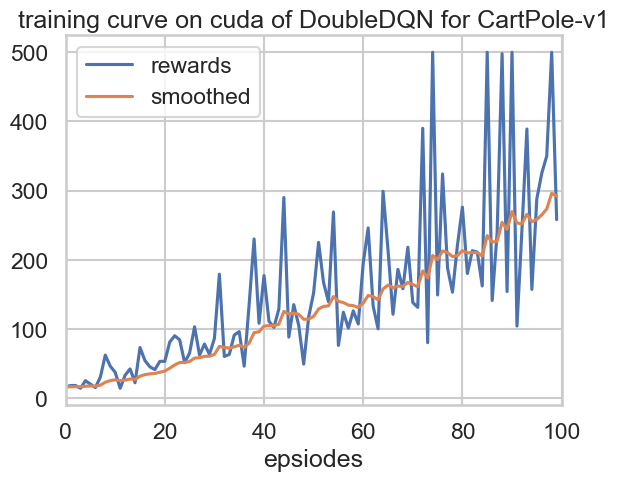

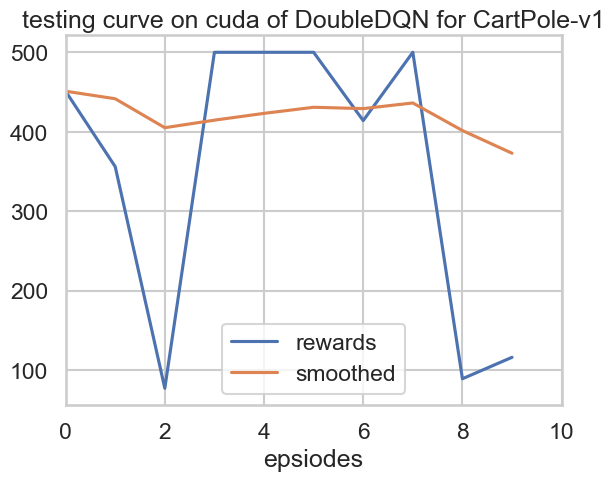

In [98]:
cfg = cnfig()
env,agent = env_agent_config(cfg)
res_dic = train(cfg,env,agent)
plot_rewards(res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  # 画出结果